In [1]:
import networkx as nx 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import pandas as pd
import json

from collections import defaultdict
%matplotlib inline 


def lineplot(x,y,xlabel,ylabel,scale=True):
    
    fig = plt.figure(figsize=(4,3))
    
    ax = fig.add_subplot(111)
    
    sns.lineplot(x=x,y=y,ax=ax)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if scale:
        
        ax.set_yscale('log')
    fig.tight_layout()
    fig.show()
    return ax

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#### Reading the files 

DF_epo_citations = pd.read_csv('data/Patents/EPO_citation_UK_withIPC_loc.csv', header=0,sep=',')
DF_pct_citations = pd.read_csv('data/Patents/PCT_citation_UK_withIPC_loc.csv', header=0,sep=',',index_col=0)
UK_patents_cited = pd.read_csv('data/Patents/UK_Patents_cited_wIPC.csv', header=0,sep=',')

In [3]:
### sorting the files by their application years and only considering the citations that are from
### within the UK both citing and the cited 

DF_epo_citations = DF_epo_citations.sort_values(by = ['app_year'])
DF_epo_citations = DF_epo_citations[DF_epo_citations['ctry_code']=='GB']


DF_pct_citations = DF_pct_citations.sort_values(by= ['app_year'])
DF_pct_citations = DF_pct_citations[DF_pct_citations['ctry_code']=='GB']

In [4]:
## checking if the app numbers are indeed EPO numbers

len([i[:2] == 'EP' for i in DF_epo_citations.app_nbr.values])/len(DF_epo_citations.app_nbr.values) 

1.0

In [5]:
Edges_1 = []

for i,j,k in zip(DF_epo_citations.Citing_app_nbr.values, DF_epo_citations.Cited_App_nbr.values,\
                 DF_epo_citations.app_year.values):
    
    Edges_1.append([i,j,k])

In [6]:
Edges_2 = []

for i,j,k in zip(DF_pct_citations.Citing_app_nbr_EPO.values, DF_pct_citations.Cited_App_nbr_EPO.values,\
                DF_pct_citations.app_year.values):
    
    Edges_2.append([i,j,k])

In [7]:
All_Edges = Edges_1 + Edges_2

len(All_Edges),len(Edges_1),len(Edges_2)

(40389, 32279, 8110)

In [8]:
#### checking for repeat edges 

edge_count = defaultdict(int)

for i in All_Edges:
    
    i = [str(k) for k in i]
    j = ','.join(i)
    edge_count[j]+=1


print(' Number of unique edges in the patent citation network are --- %d'%(len(edge_count)))

 Number of unique edges in the patent citation network are --- 19767


In [9]:
Clean_Edges = []

for i in edge_count:
    
    Clean_Edges.append(i)

In [10]:
# with open('data/UK_patent_citations.csv', 'w') as f:
    
#     f.write('source,target,time\n')
    
#     for i in tqdm(Clean_Edges):
        
        
#         f.write(f'{i}\n')

In [11]:
## Biotech: A61K35/[12-79], C07K(4, 14, 16, 17, 19),  C40B(10, 40/02-08, 50/06), G01N33/(53,54,55,57,68,74,76,78,88,92), G06F19/[10-18,20-24]

codes1 = ['A01H01','A01H04','A01K067','A61K038','A61K039','A61K048','C02F03/34','C07G011','C07G013','C07G015','C12M0',\
 'C12N0', 'C12P0', 'C12Q0','G01N027/327', 'C40B010','C40B050/06',]
    
def create_code(input1,rng):
    
    codes = []
    
    for i in rng:
        
        codes.append(input1+'%d'%(i))
    
    return codes

In [12]:
codes2 = create_code('A61K035/',range(12,80))
codes3 = create_code('C07K0',(4, 14, 16, 17, 19))
codes4 = create_code('C40B040/0',range(2,9))
codes5 = create_code('G01N033/',(53,54,55,57,68,74,76,78,88,92))
codes6 = create_code('G06F019/',range(10,19))
codes7 = create_code('G06F019/',range(20,25))

codes = codes1+codes2+codes3+codes4+codes5+codes6+codes7

codes.sort()
Biotech_codes = codes

In [13]:
G = nx.DiGraph()

for i in edge_count:
    i = i.split(',')
    G.add_edge(i[0],i[1])

In [14]:
# G.edges()

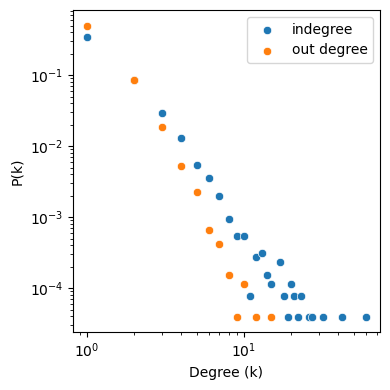

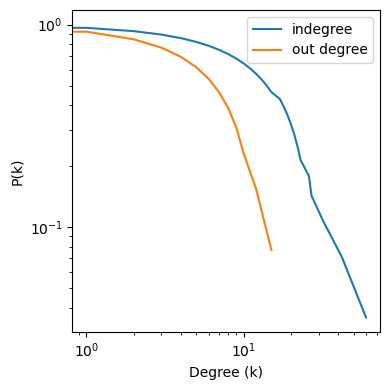

In [15]:
In_degree_dist = [j for i,j in dict(G.in_degree()).items()]

Out_degree_dist = [j for i,j in dict(G.out_degree()).items()]

def degree_dist(L):
    
    x,y = np.unique(L,return_counts=True)
    
    return x,y/sum(y)

def ccdf(L):
    
    Ls = np.sort(np.unique(L))
    
    ccdf = np.zeros(len(Ls))
    
    for i,val in enumerate(Ls):
        
        ccdf[i] = np.sum(Ls>=val)/len(Ls)
        
    return Ls,ccdf

k_i,P_ki = degree_dist(In_degree_dist)
k_o,P_ko = degree_dist(Out_degree_dist)

k_i,ccdf_ki = ccdf(In_degree_dist)
k_o,ccdf_ko = ccdf(Out_degree_dist)

plt.figure(figsize=(4,4))
sns.scatterplot(x=k_i,y=P_ki,label='indegree')
sns.scatterplot(x=k_o,y=P_ko,label='out degree')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Degree (k)')
plt.ylabel('P(k)')
plt.tight_layout()
plt.savefig('pdf_scatter.png',dpi=1000)


plt.figure(figsize=(4,4))
sns.lineplot(x=k_i,y=ccdf_ki,label='indegree')
sns.lineplot(x=k_o,y=ccdf_ko,label='out degree')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (k)')
plt.ylabel('P(k)')

plt.tight_layout()
plt.savefig('ccdf.png',dpi=1000)

In [16]:
In_degree_nodes = G.in_degree()

In [17]:
In_degree_nodes = sorted(dict(In_degree_nodes).items(),key=lambda x:x[1],reverse=True)

In_degree_nodes[:10]

[('EP19870302620', 60),
 ('EP20030290754', 42),
 ('EP19910920852', 32),
 ('EP19830306636', 27),
 ('EP19840301996', 26),
 ('EP19790302978', 23),
 ('EP19940926320', 23),
 ('EP19820300416', 22),
 ('EP19870302296', 21),
 ('EP19900915148', 21)]

In [18]:
patent_ipcs = {}

with open('epo_to_IPCs.json','r') as f:
    
    patent_ipcs = json.load(f)
    

for i in patent_ipcs:
    
    patent_ipcs[i] = patent_ipcs[i].strip()
    patent_ipcs[i] = patent_ipcs[i].replace(' ','0')
    
    new_ipcs = [j+'0' if len(j)==4 else j for j in patent_ipcs[i].split(',')]
    
    patent_ipcs[i] = ','.join(new_ipcs)
#     if len(patent_ipcs[i]) == 4:
#         patent_ipcs[i] = patent_ipcs[i]+'0'
        
#     patent_ipcs[i] = [j+'0' for j in patent_ipcs[i].split(',') if len(j)==4]
#     patent_ipcs[i] = ','.join(patent_ipcs[i])

In [19]:
def check_If_ipc(ipc,Biotech_codes):
    
    for bipc in Biotech_codes:
        
        if (ipc == bipc) or (ipc in bipc):
            
            return True
    

In [20]:
#### old method -- matching the entire string -- not correct completely 

# biotech_patents = []

# for i in tqdm(G.nodes()):
    
#     nodes_ipc = [j for j in patent_ipcs[i].split(',')]
    
#     if len(set(nodes_ipc).intersection(set(Biotech_codes))) > 0:
        
#         biotech_patents.append((i,G.in_degree(i)))
        
        
### new method 

biotech_patents = []

for i in tqdm(G.nodes()):
    
    nodes_ipc = patent_ipcs[i].split(',')
    
    for nipc in nodes_ipc:
        
        flag = check_If_ipc(nipc,Biotech_codes)
        
        if flag:
            
            biotech_patents.append((i,G.in_degree(i)))
                


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25857/25857 [00:00<00:00, 64803.55it/s]


In [21]:
len(set(biotech_patents))

418

In [22]:
biotech_patents = list(set(biotech_patents))

In [23]:
len(set(Biotech_codes))

121

In [24]:
len(G.nodes())

25857

In [25]:
biotech_patents = sorted(biotech_patents,key=lambda x:x[1],reverse=True)

In [26]:
import regex as re

In [27]:
biotech_patents = [i for i in biotech_patents if i[1]>0]
biotech_patents_C = [i[0] for i in biotech_patents]

In [28]:
biotech_patents_new_df = pd.read_csv('data/biotec_IPC.csv',header=0,sep=',')

In [29]:
biotech_patents_M = biotech_patents_new_df.app_nbr.values
biotech_patents_new = biotech_patents_new_df.app_nbr.values

In [30]:
diff = list(set(biotech_patents_M) - set(biotech_patents_C))

In [31]:
# list(map(lambda x: len(set(patent_ipcs[x].split(',')).intersection(set(Biotech_codes))), diff))

In [32]:
patent_ipcs[biotech_patents[0][0]]

'C12Q0,C12Q001/04,C12Q001/48,C12Q001/66'

In [33]:
patent_ipcs[diff[0]]

'A01K067/027,A61K031/4985,A61K031/517,A61K031/519,A61K038/00,A61K038/16,A61K038/43,A61K038/45,A61K038/46,A61K038/53,A61K045/00,A61P005/08,A61P005/10,A61P007/12,A61P009/04,A61P009/10,A61P009/12,A61P013/00,A61P015/00,A61P015/16,A61P021/00,A61P043/00,C07D0403/04,C07D0405/14,C07D0471/14,C07D0487/04,C12N005/10,C12N009/16,C12N015/09,C12N015/85,C12Q001/02,C12Q001/44,C12Q001/68,G01N033/15,G01N033/50'

In [34]:
len(diff)

484

In [35]:
len(biotech_patents_M),len(biotech_patents_C)

(627, 198)

In [36]:
diff_cm = list(set(biotech_patents_C)-set(biotech_patents_M))

In [37]:
patent_ipcs[diff_cm[0]]

'A61K0,A61K008/41,A61K008/49,A61K008/73,A61Q005/02,A61Q005/12,C07D0213/89'

In [38]:
G.in_degree(diff_cm[0])

1

In [39]:
len(diff_cm)

55

In [40]:
diff_cm[0]

'EP19790301208'

In [41]:
patent_ipcs[diff_cm[0]]

'A61K0,A61K008/41,A61K008/49,A61K008/73,A61Q005/02,A61Q005/12,C07D0213/89'

In [42]:
len(biotech_patents_C)

198

In [43]:
len(set(biotech_patents_C).intersection(set(biotech_patents_M)))

143

In [44]:
with open('epo_to_IPCs.json','r') as f:
    
    patent_ipcs_0 = json.load(f)

In [45]:
patent_ipcs_0[diff_cm[0]]

'A61K,A61K008/41,A61K008/49,A61K008/73,A61Q005/02,A61Q005/12,C07D 213/89'

In [46]:
biotech_patents = [(i,G.in_degree(i)) for i in biotech_patents_new]

In [47]:
biotech_patents = sorted(biotech_patents,key=lambda x:x[1],reverse=True)

In [48]:
biotech_patents[:10]

[('EP19870302620', 60),
 ('EP19840301996', 26),
 ('EP19820300416', 22),
 ('EP19880310000', 17),
 ('EP19870307668', 15),
 ('EP19860303039', 13),
 ('EP19870305732', 13),
 ('EP19880303157', 12),
 ('EP19970947810', 11),
 ('EP19790301773', 10)]

In [49]:
patent_ipcs[biotech_patents[0][0]]

'A61K039/395,C07K014/005,C07K014/195,C07K016/00,C07K016/46,C07K019/00,C12N005/00,C12N005/10,C12N015/00,C12N015/09,C12P021/00,C12P021/02,C12P021/08,C12R001/91'

In [50]:
biotech_patents_nodes = [i[0] for i in biotech_patents]

In [51]:
len(biotech_patents)/len(G)

0.024248752755540087

In [52]:
G_biotech = nx.subgraph(G,biotech_patents_nodes)

In [53]:
node_color = ['red' if n in biotech_patents_nodes else 'black' for n in G.nodes]

In [54]:
with open('nodes_file.csv','w') as f:
    
    for i,j in zip(G.nodes,node_color):
        f.write(f'{i},{j}\n')

In [55]:
cit_df = pd.read_csv('data/UK_patent_citations.csv',header=0,sep=',')

In [56]:
cit_df_grouped = cit_df.groupby('time')

In [57]:
x,y = list(cit_df_grouped.groups.keys()), cit_df_grouped.size()

/var/folders/nh/5jq2mlf15kvc6qs_xh074tn80000gn/T/ipykernel_55313/3622891455.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: xlabel='Years', ylabel='Citations'>

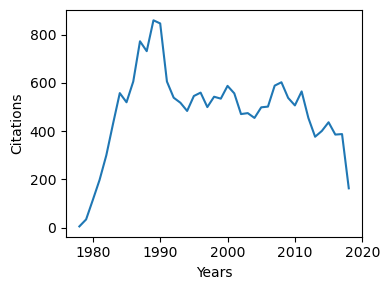

In [58]:
lineplot(x[:-1],y[:-1],'Years','Citations',scale=False)

In [59]:
biotech_patents[:10]

[('EP19870302620', 60),
 ('EP19840301996', 26),
 ('EP19820300416', 22),
 ('EP19880310000', 17),
 ('EP19870307668', 15),
 ('EP19860303039', 13),
 ('EP19870305732', 13),
 ('EP19880303157', 12),
 ('EP19970947810', 11),
 ('EP19790301773', 10)]

In [60]:
ipc_count = defaultdict(int)

for i in patent_ipcs:
    for j in patent_ipcs[i].split(','):
        
        ipc_count[j]+=1
        
ipc_count = dict(ipc_count)

In [61]:
N = sum(ipc_count.values())
p_ipc = {i:ipc_count[i]/N for i in ipc_count}

In [62]:
def get_shannon_entropy(pat,p_ipc):
    
    ipcs = patent_ipcs[pat].split(',')
    
    return -sum([p_ipc[i]*np.log(p_ipc[i]) for i in ipcs])

In [63]:
patents_entropy = {i:get_shannon_entropy(i,p_ipc) for i in patent_ipcs}

In [64]:
patents_entropy = {i:j for i,j in sorted(patents_entropy.items(),key=lambda x:x[1],reverse=True)}

In [65]:
patents_entropy_val = patents_entropy.values()

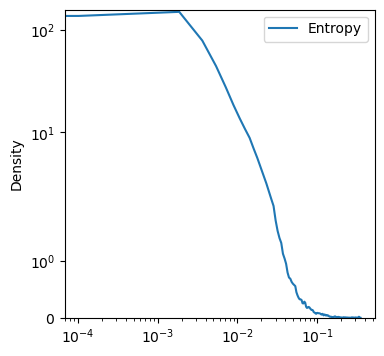

In [66]:
plt.figure(figsize=(4,4))
sns.kdeplot(patents_entropy_val,label='Entropy')
plt.yscale('symlog')
plt.xscale('log')
plt.legend()

In [67]:
nodes_ipcs = {n:patent_ipcs[n] for n in G.nodes}

data_entropy = {i:get_shannon_entropy(i,p_ipc) for i in nodes_ipcs}

In [68]:
class Entropy_msrs:
    
    def __init__(self,data,depth):
        self.data = data
        self.depth = depth  ### level at which we look into the entropy
        
        self.unique_ipcs = self.get_ipcs()
        self.Prob_ipcs = self.get_probability()
        
        return None
    
    def get_ipcs(self):
        
        ipcs = []
        
        for i in self.data:
            
            ipcs.extend([j if self.depth==0 else j[:self.depth] for j in i.split(',')])
        
        ipcs = list(set(ipcs))
        
        return ipcs
    
    def get_probability(self):
        
        ipc_count = defaultdict(int)

        for i in self.data:
            for j in self.data[i].split(','):
                
                if self.depth == 0:
                    
                    ipc_count[j]+=1
                else:
                    ipc_count[j[:self.depth]]+=1

        ipc_count = dict(ipc_count)
        N = sum(ipc_count.values())
        p_ipc = {i:ipc_count[i]/N for i in ipc_count}
        
        return p_ipc
    
    def get_shannon_entropy(self,pat):
    
        p_ipc = self.Prob_ipcs
        ipcs = [j if self.depth==0 else j[:self.depth] for j in self.data[pat].split(',')]
    
        return -sum([p_ipc[i]*np.log(p_ipc[i]) for i in ipcs])
    
    def get_data_entropy(self):
        
        p_ipc = self.Prob_ipcs
        
        return -sum([p_ipc[i]*np.log(p_ipc[i]) for i in p_ipc])
    
#     def get_ccdf(self,Prob_dict):
        
#         vals = list(Prob_dict.values())
        
#         vals = np.sort(vals)
        
#         ccdf = np.zeros(len(vals))
        
#         N = float(len(vals))
#         for i in range(int(N)):
            
#             ccdf[i] = np.sum(vals>=vals[i])/N
            
#         return ccdf
    
    def get_jaccard():
        
        return None 
        

In [69]:
E1 = Entropy_msrs(patent_ipcs,0)
E2 = Entropy_msrs(nodes_ipcs,0)

In [70]:
prob_dict = E2.get_probability()
prob_dict1 = E1.get_probability()

In [71]:
prob_dict = {i:j for i,j in sorted(prob_dict.items(), key=lambda x:x[1])}

In [72]:
E2.get_data_entropy()/E1.get_data_entropy()

0.9530507741652402

In [73]:
prob_dict['H01H033/18']

6.0132291040288637e-05

In [74]:
E2.get_shannon_entropy('EP19790302618')

0.0005844235461327104

In [75]:
cited_nodes = [n for n in G.nodes() if G.in_degree(n)>0]

In [76]:
colors = ['darkred' if n in biotech_patents_nodes else 'lightgray' for n in cited_nodes]

In [142]:
Graph_Ent = Entropy_msrs(nodes_ipcs,0)

In [143]:
# Graph_Ent.get_probability()

In [397]:
Cit,Div_se = [],[]
for n in tqdm(cited_nodes):
# for n in tqdm(biotech_patents_nodes):
    nbrs_n = list(G.predecessors(n))
    
    
    div = [Graph_Ent.get_shannon_entropy(i) for i in nbrs_n]
    
    
    Cit.append(len(nbrs_n))
    
    Div_se.append(np.max(div))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12545/12545 [00:00<00:00, 99620.48it/s]


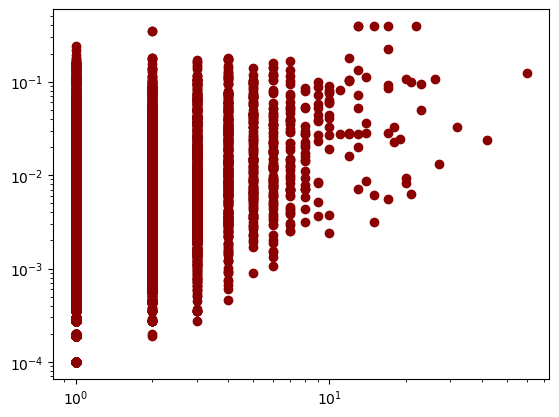

In [398]:
# plt.scatter(Cit,Div_se,color=colors)
plt.scatter(Cit,Div_se,color='darkred')
plt.yscale('log')
plt.xscale('log')

In [399]:
from scipy.stats import spearmanr,pearsonr
# from scipy.stats import binned_statistic as bin1d

In [400]:
X_,Y_,yerr_ = [],[],[]

Cit_div = {}

for i,j in zip(Cit,Div_se):
    
    if i not in Cit_div:
        
        Cit_div[i] = [j]
        
    else:
        Cit_div[i].append(j)

In [401]:
Cit_div = {i:j for i,j in sorted(Cit_div.items(),key = lambda x:x[0])}

In [402]:
for i in Cit_div:
    
    X_.append(i)
    
    Y_.append(np.mean(Cit_div[i]))
    
    yerr_.append(np.std(Cit_div[i])/np.sqrt(len(Cit_div[i])))

In [403]:
spr0 = spearmanr(X_,Y_) ### two-sided p-value, null == np correlation
spr1 = spearmanr(Cit,Div_se)

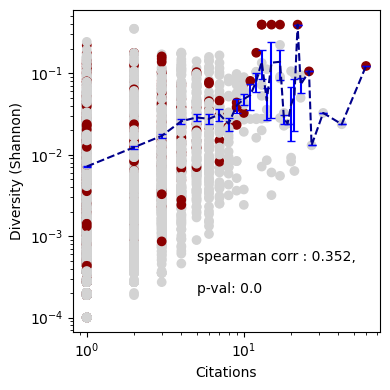

In [406]:
plt.figure(figsize=(4,4))
plt.scatter(Cit,Div_se,color=colors)
# plt.scatter(Cit,Div_se,color='darkred')
plt.errorbar(X_,Y_,yerr=yerr_,ecolor='blue',capsize=3,linestyle='--',color='darkblue')
plt.yscale('log')
plt.xscale('log')

plt.text(5,0.0002,f'spearman corr : {np.round(spr1.statistic,3)},\n\np-val: {np.round(spr1.pvalue,2)}')

plt.ylabel('Diversity (Shannon)')
plt.xlabel('Citations')

plt.tight_layout()
plt.savefig('div_vs_cit_shan_maxD_all.pdf')
plt.savefig('div_vs_cit_shan_maxD_all.png')

In [206]:
import random as rd

In [207]:
def Randomize(N_iter):
    
    R_spr = []
    pval = []
    R_spr2 = []
    pval2 = []
    
    sample_set = list(set(cited_nodes) - set(biotech_patents_nodes))
    
    for i in tqdm(range(N_iter)):
        
        random_nodes = np.random.choice(sample_set,len(biotech_patents_nodes),replace=False)
        
        
        
        Cit,Div_se = [],[]
        # for n in tqdm(cited_nodes):
        for n in random_nodes:
            nbrs_n = list(G.predecessors(n))


            div = [Graph_Ent.get_shannon_entropy(i) for i in nbrs_n]


            Cit.append(len(nbrs_n))

            Div_se.append(np.max(div))
        
        
        spr0 = spearmanr(Cit,Div_se)
        R_spr.append(spr0.statistic)
        pval.append(spr0.pvalue)
        
        X_,Y_,yerr_ = [],[],[]

        Cit_div = {}

        for i,j in zip(Cit,Div_se):

            if i not in Cit_div:

                Cit_div[i] = [j]

            else:
                Cit_div[i].append(j)

        Cit_div = {i:j for i,j in sorted(Cit_div.items(),key = lambda x:x[0])}

        for i in Cit_div:

            X_.append(i)

            Y_.append(np.mean(Cit_div[i]))

            yerr_.append(np.std(Cit_div[i])/np.sqrt(len(Cit_div[i])))

        spr2 = spearmanr(X_,Y_)
        
        pval2.append(spr2.pvalue)

        R_spr2.append(spr2.statistic)
    
    return R_spr,pval,R_spr2,pval2



In [208]:
R_spr1,pval1,R_spr2,pval2 = Randomize(1000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.74it/s]


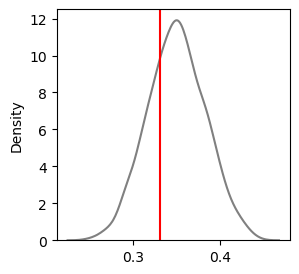

In [253]:
plt.figure(figsize=(3,3))
clean_Rspr = [i for i,j in zip(R_spr1,pval1) if j <= 0.01]

sns.kdeplot(clean_Rspr,color='gray')
plt.axvline(spr1.statistic,color='red')

In [410]:
def check_if_in_biotech(x,Biotech_codes=Biotech_codes):
    
    x_ipcs = patent_ipcs[x].split(',')
    
    flag = False
    for bipc in Biotech_codes:
        
        for xi in x_ipcs:
        
            if (bipc == xi) or (bipc in xi):
            
                flag = True
                break
    return flag

def prop_citations_from_biotech(target,G):
    
    nbrs_n = list(G.predecessors(target))
    N = len(nbrs_n)
    
    from_biotech = np.zeros(N)
    
    for i,n in enumerate(nbrs_n):
        
        flag = check_if_in_biotech(n)
        
        if flag:
            from_biotech[i] = 1
    
    return sum(from_biotech)/N

In [411]:
epo_to_yr_df = pd.read_csv('data/EPO_to_IPC_year.csv',header=0,sep=',',index_col=0)

In [412]:
epo_to_yr_df.dropna(inplace=True)

In [413]:
node_yr = {i:int(j) for i,j in zip(epo_to_yr_df.index.values,epo_to_yr_df.app_year.values)}

In [414]:
def filter_dt(dt):
    
    if dt < 0 and dt >= -3:
        return 0
    elif dt<-3:
        return np.nan
    else:
        return dt

In [415]:
delta_T,Div_se = [],[]

for n in tqdm(cited_nodes):
# for n in tqdm(biotech_patents_nodes):
    
    nbrs_n = list(G.predecessors(n))
    div_sub = [] 
    
#     dt = [node_yr[i] - node_yr[n] for i in nbrs_n]
    dt_sub = []
    
    for i in nbrs_n:
        
        dt = filter_dt(node_yr[i] - node_yr[n])
        div = Graph_Ent.get_shannon_entropy(i)
        
        dt_sub.append(dt)
        div_sub.append(div)
    delta_T.extend(dt_sub)
    
    Div_se.extend(div_sub)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12545/12545 [00:00<00:00, 113052.68it/s]


In [416]:
len(delta_T),len(Div_se)

(19767, 19767)

In [417]:
delta_T = np.array(delta_T)
Div_se = np.array(Div_se)

In [418]:
indx = np.where(delta_T!=np.nan)

In [419]:
delta_T = delta_T[indx]
Div_se = Div_se[indx]

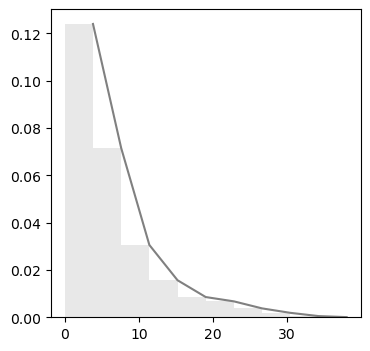

In [420]:
plt.figure(figsize=(4,4))
y,x,_ = plt.hist(list(delta_T),density=True,color='lightgray',alpha=0.5)
plt.plot(x[1:],y,color='gray')

/var/folders/nh/5jq2mlf15kvc6qs_xh074tn80000gn/T/ipykernel_55313/969955511.py:5: RuntimeWarning: overflow encountered in exp
  return b*np.exp(-l*x)


[0.16995148 0.23947067]


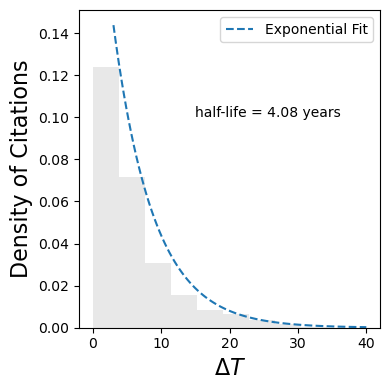

In [455]:
from scipy.optimize import curve_fit

def f_exp(x,l,b):
    
    return b*np.exp(-l*x)

params,pcov = curve_fit(f_exp,x[1:],y)
print(params)

x1 = np.linspace(3,40,100)

plt.figure(figsize=(4,4))
y,x,_ = plt.hist(list(delta_T),density=True,color='lightgray',alpha=0.5)
# plt.plot(x[1:],y,color='gray')
plt.plot(x1,f_exp(x1,*params),'--',label='Exponential Fit')
plt.ylabel('Density of Citations',fontsize=16)
plt.xlabel(r'$\Delta T$',fontsize=16)
plt.text(15,0.10,r'half-life = %0.2f years'%(half_life))
plt.legend()
plt.tight_layout()
plt.savefig('half_life_cit.png',dpi=500)
plt.savefig('half_life_cit.pdf')

In [422]:
half_life = np.log(2)/params[0]
half_life

4.078500440777193

In [423]:
from scipy.stats import binned_statistic as bin1d

In [424]:
xt,yt,yerrt = [],[],[]

div_t = {}

for i,j in zip(delta_T,Div_se):
    
    if i not in div_t:
        
        div_t[i] = [j]
    else:
        div_t[i].append(j)

In [425]:
div_t = {i:j for i,j in sorted(div_t.items(),key=lambda x:x[0])}

In [426]:
for i in div_t:
    
    xt.append(i)
    yt.append(np.mean(div_t[i]))
    yerrt.append(np.std(div_t[i])/len(div_t)**0.5)

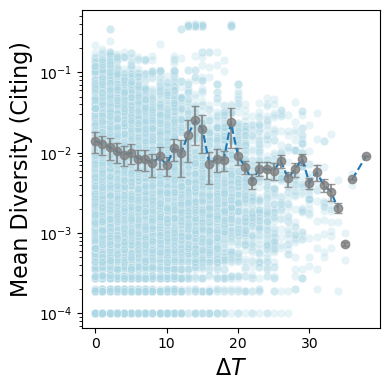

In [443]:
plt.figure(figsize=(4,4))
plt.errorbar(xt,yt,yerrt,capsize=3,color='gray',ecolor='gray',fmt='o',alpha=0.8)
plt.plot(xt,yt,'--')
sns.scatterplot(x=delta_T,y=Div_se,alpha=0.3,color='lightblue');
plt.xlabel(r'$\Delta T$',fontsize=16)
plt.ylabel('Mean Diversity (Citing)',fontsize=16)
plt.yscale('log')
plt.tight_layout()
plt.savefig('mean_diversity_deltaT.png',dpi=600)
plt.savefig('mean_diversity_deltaT.pdf')
plt.show()


In [233]:
#### Regions 

delta_T = delta_T[np.where(delta_T!=np.nan)]
Div_se = Div_se[np.where(delta_T!=np.nan)]


In [234]:
pearsonr(xt[:-7],yt[:-7])

PearsonRResult(statistic=-0.45881699207202103, pvalue=0.005567174419263755)

In [235]:
from statsmodels.regression import linear_model

In [236]:
# help(linear_model)

In [237]:
# delta_T = delta_T[np.where(delta_T!=np.nan)]
# Div_se = Div_se[np.where(delta_T!=np.nan)]
model = linear_model.OLS(yt[:-7],xt[:-7])

In [238]:
res = model.fit()

In [239]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.404
Model:                            OLS   Adj. R-squared (uncentered):              0.386
Method:                 Least Squares   F-statistic:                              23.01
Date:                Thu, 29 Jun 2023   Prob (F-statistic):                    3.14e-05
Time:                        18:27:15   Log-Likelihood:                          118.40
No. Observations:                  35   AIC:                                     -234.8
Df Residuals:                      34   BIC:                                     -233.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0003   7.12e-05      4.797      0.000       0.000       0.000
==============================================================================
Omnibus:                        1.300   Durbin-Watson:                   0.376
Prob(Omnibus):                  0.522   Jarque-Bera (JB):                1.203
Skew:                           0.311   Prob(JB):                        0.548
Kurtosis:                       2.338   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [446]:
with open('Patents_info_all.csv','w') as f:
    
    f.write('id,diversity,citations,year,region,is_Biotech\n')

    for i in G.nodes():
    
        uid,div,cit,yr,region = i,Graph_Ent.get_shannon_entropy(i),G.in_degree(i),node_yr[i],patentsID_to_region[i]
        if i in biotech_patents_nodes:
            is_Biotech=1
        else:
            is_Biotech=0
        #         print(i,Graph_Ent.get_shannon_entropy(i),G.in_degree(i))
        f.write(f'{uid},{np.round(div,4)},{cit},{yr},{region},{is_Biotech}\n')

In [254]:
patentsID_to_region = {} 

for i,j in zip(DF_pct_citations.Citing_app_nbr_EPO.values, DF_pct_citations.reg_code.values):
    
    if i not in patentsID_to_region:
        
        patentsID_to_region[i] = j
        
for i,j in zip(DF_epo_citations.Citing_app_nbr.values, DF_epo_citations.reg_code.values):
    
    if i not in patentsID_to_region:
        
        patentsID_to_region[i] = j
        
for i,j in zip(UK_patents_cited.app_nbr.values, UK_patents_cited.reg_code.values):
    
    if i not in patentsID_to_region:
        
        patentsID_to_region[i] = j

In [283]:
patents_info = pd.read_csv('Patents_info.csv',header=0,sep=',')

In [284]:
patents_info = patents_info.sort_values(by='year')

In [285]:
patents_info_groupd_bT = patents_info.groupby('is_Biotech')

In [295]:
patents_info_groupd_bT.get_group(1).sort_values(by='citations')

,id,diversity,citations,year,region,is_Biotech
876,EP19780100395,0.0049,1,1978,UKJ42,1
11201,EP19980938832,0.0110,1,1998,UKL22,1
8168,EP19980957019,0.0173,1,1998,UKJ42,1
10620,EP19980940467,0.0014,1,1998,UKJ24,1
12525,EP19980932298,0.0181,1,1998,UKE12,1
...,...,...,...,...,...,...
2449,EP19870307668,0.0261,15,1987,UKF16,1
2783,EP19880310000,0.0889,17,1988,UKF16,1
6732,EP19820300416,0.0499,22,1982,UKD61,1
7122,EP19840301996,0.1200,26,1984,UKJ11,1


In [271]:
patents_info

,id,diversity,citations,year,region,is_Biotech
1642,EP19780300180,0.0073,1,1978,UKF22,0
5630,EP19780300248,0.0009,1,1978,UKL21,0
163,EP19780200049,0.0289,4,1978,UKC22,0
656,EP19780300224,0.0021,2,1978,UKJ14,0
171,EP19780300375,0.0004,1,1978,UKE32,0
...,...,...,...,...,...,...
9751,EP20180020259,0.0019,1,2018,UKG24,0
9816,EP20180159114,0.0028,1,2018,UKF11,0
9774,EP20180212257,0.0025,1,2018,UKJ23,0
9763,EP20180155163,0.0033,1,2018,UKK12,0


In [307]:
def Correlation_plots(node_list,ax,label):
    

    Cit,Div_se = [],[]

    for n in node_list:
        nbrs_n = list(G.predecessors(n))


        div = [Graph_Ent.get_shannon_entropy(i) for i in nbrs_n]


        Cit.append(len(nbrs_n))

        Div_se.append(np.max(div))

    ax.scatter(Cit,Div_se,label=label)
    
    spr_all = spearmanr(Cit,Div_se)

    X_,Y_,yerr_ = [],[],[]

    Cit_div = {}

    for i,j in zip(Cit,Div_se):

        if i not in Cit_div:

            Cit_div[i] = [j]

        else:
            Cit_div[i].append(j)

    Cit_div = {i:j for i,j in sorted(Cit_div.items(),key = lambda x:x[0])}

    for i in Cit_div:

        X_.append(i)

        Y_.append(np.mean(Cit_div[i]))

        yerr_.append(np.std(Cit_div[i])/np.sqrt(len(Cit_div[i])))

    spr_mean = spearmanr(X_,Y_)

   
    return spr_all,spr_mean



In [303]:
def get_region_nodes(reg_code,df):
    
    nList = []
    
    for i,j in zip(df.id,df.region):
        
        if (j == reg_code) and (i in biotech_patents_nodes):
            nList.append(i)
    
    return nList

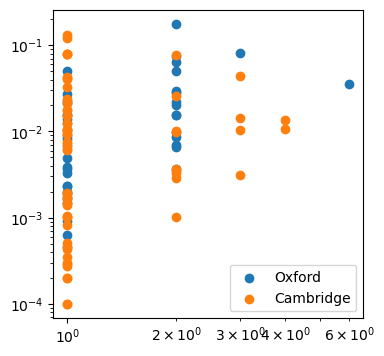

In [309]:
oxford ='UKJ14'
cambridge = 'UKH12'

oxford_nodes = get_region_nodes(oxford,patents_info)
cambridge_nodes = get_region_nodes(cambridge,patents_info)


fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111)

Correlation_plots(oxford_nodes,ax,'Oxford')
Correlation_plots(cambridge_nodes,ax,'Cambridge')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [317]:
# sns.kdeplot(patents_info.diversity.values)

In [320]:
def Randomize_two(N_iter,G):
    
    '''
    We shuflle the nodes edges to get the random null model of the graph preserving the degrees
    and do the same calculations as we did for the nodes in 
    the biotech nodes
    
    '''
    
    R_spr = []
    pval = []
    R_spr2 = []
    pval2 = []
    
    nodes = list(G.nodes())
    
    in_seq = [G.in_degree(i) for i in nodes]
    out_seq = [G.out_degree(i) for i in nodes]
    
    for i in tqdm(range(N_iter)):
        
        
        Gr = nx.directed_configuration_model(in_seq,out_seq)
        
        nmap_true_to_rand = {i:j for i,j in zip(nodes,Gr.nodes())}
        nmap_rand_to_true = {j:i for i,j in zip(nodes,Gr.nodes())}
        
        Cit,Div_se = [],[]
        # for n in tqdm(cited_nodes):
        for n in biotech_patents_nodes:
            
            nbrs_n = list(Gr.predecessors(nmap_true_to_rand[n]))


            div = [Graph_Ent.get_shannon_entropy(nmap_rand_to_true[i]) for i in nbrs_n]


            Cit.append(len(nbrs_n))

            Div_se.append(np.max(div))
        
        
        spr0 = spearmanr(Cit,Div_se)
        R_spr.append(spr0.statistic)
        pval.append(spr0.pvalue)
        
        X_,Y_,yerr_ = [],[],[]

        Cit_div = {}

        for i,j in zip(Cit,Div_se):

            if i not in Cit_div:

                Cit_div[i] = [j]

            else:
                Cit_div[i].append(j)

        Cit_div = {i:j for i,j in sorted(Cit_div.items(),key = lambda x:x[0])}

        for i in Cit_div:

            X_.append(i)

            Y_.append(np.mean(Cit_div[i]))

            yerr_.append(np.std(Cit_div[i])/np.sqrt(len(Cit_div[i])))

        spr2 = spearmanr(X_,Y_)
        
        pval2.append(spr2.pvalue)

        R_spr2.append(spr2.statistic)
    
    return R_spr,pval,R_spr2,pval2



In [323]:
Rspr,pval1,_,_ = Randomize_two(1000,G)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:18<00:00,  7.21it/s]


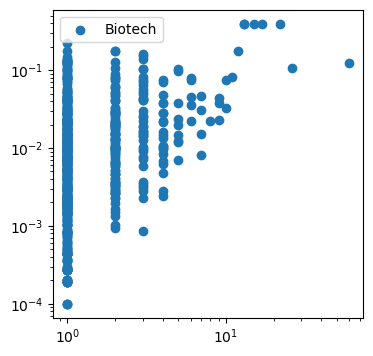

In [326]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111)

corr_all,corr_mean = Correlation_plots(biotech_patents_nodes,ax,'Biotech')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [328]:
corr_all.statistic,corr_all.pvalue

(0.3309478235598425, 1.7186000490988683e-17)

In [329]:
Rand_corr = [i for i,j in zip(Rspr,pval1) if j < 0.05]

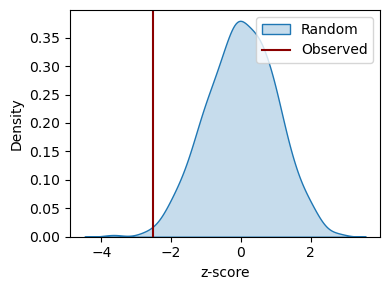

In [389]:
plt.figure(figsize=(4,3))
sns.kdeplot((Rand_corr-np.mean(Rand_corr))/np.std(Rand_corr),fill='gray',label='Random')
plt.axvline((corr_all.statistic-np.mean(Rand_corr))/np.std(Rand_corr),color='darkred',label='Observed')
plt.legend()
plt.xlabel('z-score')
plt.tight_layout()
plt.savefig('diversity_null_comparison.png',dpi=500)
plt.savefig('diversity_null_comparison.pdf')

In [346]:
(corr_all.statistic-np.mean(Rand_corr))/np.std(Rand_corr)

-2.532414911599735

In [408]:
len(cited_nodes)

12545

In [444]:
patents_info

,id,diversity,citations,year,region,is_Biotech
1642,EP19780300180,0.0073,1,1978,UKF22,0
5630,EP19780300248,0.0009,1,1978,UKL21,0
163,EP19780200049,0.0289,4,1978,UKC22,0
656,EP19780300224,0.0021,2,1978,UKJ14,0
171,EP19780300375,0.0004,1,1978,UKE32,0
...,...,...,...,...,...,...
9751,EP20180020259,0.0019,1,2018,UKG24,0
9816,EP20180159114,0.0028,1,2018,UKF11,0
9774,EP20180212257,0.0025,1,2018,UKJ23,0
9763,EP20180155163,0.0033,1,2018,UKK12,0


In [448]:
with open('biotech_nodes_labels.csv','w') as f:
    
    for i in biotech_patents_nodes:
        f.write(f'{i}\n')

In [447]:
biotech_patents_nodes

['EP19870302620',
 'EP19840301996',
 'EP19820300416',
 'EP19880310000',
 'EP19870307668',
 'EP19860303039',
 'EP19870305732',
 'EP19880303157',
 'EP19970947810',
 'EP19790301773',
 'EP19890302331',
 'EP19890303964',
 'EP19940904295',
 'EP19970941124',
 'EP19820305029',
 'EP19850904274',
 'EP19860305604',
 'EP20000947546',
 'EP20040798623',
 'EP19840115345',
 'EP19840303090',
 'EP19870306547',
 'EP19930308029',
 'EP19980310350',
 'EP19800302498',
 'EP19860112386',
 'EP19860870123',
 'EP19870304433',
 'EP19880307641',
 'EP19890910909',
 'EP19900307236',
 'EP19920301465',
 'EP20120154614',
 'EP19800300431',
 'EP19800303328',
 'EP19820301140',
 'EP19830302451',
 'EP19830307819',
 'EP19840100521',
 'EP19840300003',
 'EP19850304169',
 'EP19870201286',
 'EP19870303535',
 'EP19870900856',
 'EP19880307148',
 'EP19880906008',
 'EP19890305563',
 'EP19890306923',
 'EP19900304575',
 'EP19940913174',
 'EP20000972153',
 'EP20020755137',
 'EP20030766486',
 'EP20050256103',
 'EP20060254200',
 'EP198003

In [454]:
biotech_patents

with open('top5_biotech_nodes_labels.csv','w') as f:
    
    for i in biotech_patents[:5]:
        f.write(f'{i[0]}\n')